## Classification Methodology - Using Sckit-Learn 

In this section the data from the data manipulation and feature engineering section will be imported and manipulated one more time in order to run a Logistic regression classifier. The possibility of predicting whether a review is useful or not will be assessed and the model's performance will be measured.

Notebook 2 - Classification Methodology:

1. Data preparation - subsetting the data set, changing data types and creating dummy variables for all the categorical features
2. Preparing train and test sets
3. Classification model - Logistic regression pipeline
4. Model performance
5. Quick look at a Random Forest
6. Conclusions


In [1]:
## Import all relevent libraries to analyse the data
import pandas as pd
import numpy as np
import datetime
import math
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from scipy import stats

## This line makes sure that our graphs are rendered within the notebook
%matplotlib inline

sns.set(color_codes=True)

## Set options to display all columns
pd.set_option("display.max_columns",None)

# load
HelpfulnesswithTarget_df = pd.read_csv('HelpfulnesswithTarget_df.csv', index_col=0)

In [2]:
# Import scikit learn libraries and APIs needed
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

In [3]:
print(HelpfulnesswithTarget_df.dtypes)

Id                          int64
ProductId                  object
UserId                     object
ProfileName                object
HelpfulnessNumerator        int64
HelpfulnessDenominator      int64
Score                       int64
Time                       object
Summary                    object
Text                       object
helpfulness_ratio         float64
useful_flag                 int64
negative_rating_flag        int64
positive_rating_flag        int64
n_distinct_words            int64
n_words                     int64
clean_text                 object
n_distinct_cleanwords       int64
n_cleanwords                int64
cleanwords_ratio          float64
day_of_week                 int64
year                        int64
month                       int64
winter_flag                 int64
summer_flag                 int64
product_freq                int64
reviewer_freq               int64
dtype: object


### 1. Data preparation


First que split the data into a features matrix (X) and target vector (y)

In [4]:
# Setting data type for categorical variables
HelpfulnesswithTarget_df['day_of_week'] = HelpfulnesswithTarget_df['day_of_week'].astype('category') 
HelpfulnesswithTarget_df['month'] = HelpfulnesswithTarget_df['month'].astype('category') 

In [69]:
model_df = HelpfulnesswithTarget_df[['Score'
                                   ,'negative_rating_flag'
                                   #,'positive_rating_flag'
                                   ,'day_of_week'
                                   ,'month'
                                   ,'winter_flag'
                                   #,'summer_flag'
                                   ,'n_words'
                                   ,'product_freq'
                                   ,'reviewer_freq']]

target = HelpfulnesswithTarget_df[['useful_flag']]

Then, we turn each of the categorical variables levels into a binary variable.

In [70]:
categorical_variables = ['day_of_week', 'month']
for var in categorical_variables: # After the first look of the results I would put this in a function
    categorical_list='var'+'_'+var
    categorical_list = pd.get_dummies(model_df[var], prefix=var, drop_first=True)
    data1=model_df.join(categorical_list)
    model_df=data1
    
data_vars=model_df.columns.values.tolist()
to_keep=[i for i in data_vars if i not in categorical_variables]

model_df=model_df[to_keep]
model_df.head()

,Score,negative_rating_flag,winter_flag,n_words,product_freq,reviewer_freq,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
11,5,0,0,67,1,2,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
14,5,0,0,21,2,33,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
15,5,0,1,26,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
32,4,0,1,206,4,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
33,4,0,1,93,4,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


### 2.  Preparing train and test sets

We need to split our data into train and tests sets to measure and compare model performance 

In [71]:
X_train, X_test, y_train, y_test = train_test_split(model_df, target, test_size=0.2, random_state=42)
model_df.shape, X_train.shape, X_test.shape

((89773, 23), (71818, 23), (17955, 23))

It is known from the data exploration section that our target has more reviews tagged as useful (1) and this can bring problems to the model's results and interpretation.  One way to come around this problem is to over sample the not useful reviews, so that the resulted data set has a balanced split of target observations. This will only be done on the training data set as we want to test if the coefficients will give us an accurate prediction on the training set. 

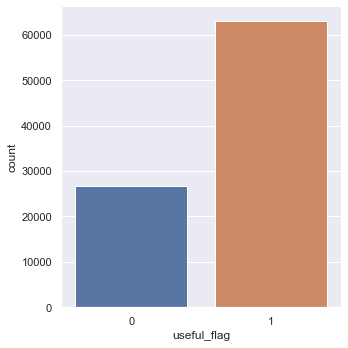

In [72]:
sns.catplot(x="useful_flag", kind="count", data = HelpfulnesswithTarget_df)

In [73]:
# Sampling up none useful reviews using SMOTE (Synthetic Minority Over-sampling Technique)
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0)
os_data_X,os_data_y=os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X, columns=X_train.columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['useful_flag'])

# Check data dimensions
print('length of oversampled data is ',len(os_data_X))
print('Number of useful_flag = 0',len(os_data_y[os_data_y['useful_flag']==0]))
print('Number of useful_flag = 1',len(os_data_y[os_data_y['useful_flag']==1]))

length of oversampled data is  100776
Number of useful_flag = 0 50388
Number of useful_flag = 1 50388


### 3. Classification model - Logistic regression pipeline
Logistic regression is a classification technique, where the output variable is either binary or a multiclass (categorical variables with different levels, like segments for example) compared to linear regression where the output is a numerical value. 

The main model assumptions are:
- Appropriate outcome type. The type of logistic regression utilized (binary, multinomial, or ordinal) must match the outcome (dependent) variable in the dataset.
- Linearity of independent variables and log-odds of the outcome
- No strongly influential outliers. Logistic regression assumes that there are no highly influential outlier data points, as they distort the outcome and accuracy of the model. 
- Absence of multicollinearity. Multicollinearity corresponds to a situation where the data contain highly correlated independent variables. 
- Independence of observations.This means that each observation is not influenced by or related to the rest of the observations.
- Sufficiently large sample size.

https://towardsdatascience.com/assumptions-of-logistic-regression-clearly-explained-44d85a22b290

In [74]:
# Logistic pipeline
data_final_vars=model_df.columns.values.tolist()

from sklearn.feature_selection import RFE
from sklearn.pipeline import make_pipeline 


def get_standard_pipeline(classfier):
    rfe = RFE(classfier, n_features_to_select=20,step=1) #recursive feature elimination 
    return make_pipeline(StandardScaler(), rfe, classfier)


pipe = get_standard_pipeline(LogisticRegression())
pipeline_model = pipe.fit(os_data_X, os_data_y.values.ravel())



In [75]:
pipeline_model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('rfe',
                 RFE(estimator=LogisticRegression(), n_features_to_select=20)),
                ('logisticregression', LogisticRegression())])

In [76]:
#Variables selected
print(pipeline_model['rfe'].support_)
print(pipeline_model['rfe'].ranking_)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True False False False]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 4 2]


In [77]:
os_data_X.columns

Index(['Score', 'negative_rating_flag', 'winter_flag', 'n_words',
       'product_freq', 'reviewer_freq', 'day_of_week_1', 'day_of_week_2',
       'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12'],
      dtype='object')

In [78]:
selected_column_names = os_data_X.columns[pipeline_model['rfe'].support_]

In [79]:
coefficient = pipeline_model['logisticregression'].coef_

In [80]:
#dict(zip(selected_column_names, coefficient.ravel()))

In [81]:
df = pd.DataFrame(coefficient.ravel(), index=selected_column_names, columns=['coefficient'])
df

,coefficient
Score,1.709466
negative_rating_flag,0.435660
winter_flag,3.837240
n_words,0.411997
product_freq,-0.222651
reviewer_freq,-0.171019
day_of_week_1,0.272220
day_of_week_2,0.277346
day_of_week_3,0.257090
day_of_week_4,0.271339


The value of the coefficients from 'day of the week' variables are all very similar; meaning there is not a lot of difference between them (which ties up with the data exploration section). But, for months there is a bit more difference, which also ties up with what was found on the data exploration part. The winter flag contributes to the useful prediction quite a lot more compared to the other variables (3.8 coefficient). Meaning if we assume everything else remains the same, reviews made in winter increase the chances of the review being useful. This also applies to certain extend to March and May months which also ties up with what was seen before.

The variable related to score is also showing to be influential in predicting whether a review is useful or not, which also makes sense with the data exploration section. The higher the score the more it contributes to the usefulness of the review. 

It would be useful to have more text mining variables associated with the review to have more information about the reviews itself and it might be the case that the actual content will be assesed better.

### 4. Model performance

Once the variables that are important are selected and the coefficients are calculated, then the model is fitted on the test set to get the prediction values of the target. Which will allow to compare the predicted results against the real resutls in order to assess model performance.

In [82]:
print('The model accuracy on test set is: {:.3f}'.format(pipeline_model.score(X_test, y_test))) 

The model accuracy on test set is: 0.778


In [83]:
# Predicting values in test set
from sklearn import metrics

y_pred = pipeline_model.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(pipeline_model.score(X_test, y_test)))

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print('Confusion matrix:')
print(confusion_matrix)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

Accuracy of logistic regression classifier on test set: 0.78
Confusion matrix:
[[ 3748  1608]
 [ 2384 10215]]
              precision    recall  f1-score   support

           0       0.61      0.70      0.65      5356
           1       0.86      0.81      0.84     12599

    accuracy                           0.78     17955
   macro avg       0.74      0.76      0.74     17955
weighted avg       0.79      0.78      0.78     17955



From the confusion matrix, the model got 13,963 (3,748 + 10,215) predictions right, and 3,992 (1,608 + 2,384) wrong from a total of 17,955 observations (reviews) on the test set. Which is where the 78% accuracy comes from. 

Looking at precision and recall, 86% of the model's positives and 61% of the negatives were correctly predicted (precision); whilst 81% of the positives observation and 70% of the negatives were predicted correctly (recall). These two metrics are a bit confusing but in general:
- **precision** assesses how many of the predictions are right
- **recall** assesses how many observations did the model get right 

As an example, let's say we have 3 true positives from the model and 4 positive observations. The precision would be 3/3, i.e. all the predictions are correct; whilst the recall is 3/4, i.e. the model missed one of the true observations. 

The importance of these 2 measures depends on the purpose of the study or the business case. For example: 
- in **Spam detection** usually **precision** is more important; since we want to **reduce the number of false positives**. We do not want our system to predict non-spam e-mails (important e-mails) as spam
- whilst in **medicine and clinical studies recall** is more important. We want to **minimize the number of false negatives**, since we don't want our model to mark a patient suffering from cancer as safe.  

Therefore, depending on the purpose and costs of the study the importance of these metrics vary. 

https://iq.opengenus.org/performance-metrics-in-classification-regression/

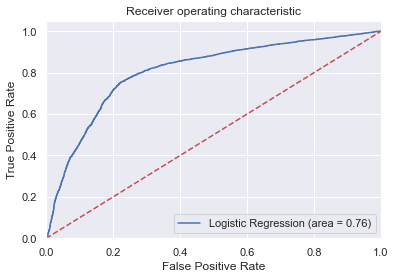

In [84]:
# ROC curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, pipeline_model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, pipeline_model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

The ROC curve is a graphical view of assessing the model's performance. The higher the AUC, better the model is at predicting 0's and 1's. If the ROC resembles the dotted redline too much then the classifier is not good at identifying the 0's and 1's. In this case, the curve does not look too bad in this case. 
An AUC of 0.77  means there is 76% chance that model will be able to distinguish between positive class and negative class.

#### Model Selection
Could also be important to have a model selection process to make sure we select the best model and also to see how it performs with different sets.

In [85]:
# Evaluate the model using 10-fold cross-validation
from sklearn.model_selection  import cross_val_score
scores = cross_val_score(pipe, os_data_X, os_data_y.values.ravel(), scoring='accuracy', cv=10)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.74756896 0.74230998 0.74578289 0.74588212 0.82258385 0.8422306
 0.83725315 0.83745162 0.83814627 0.84112335]
Accuracy: 0.80 (+/- 0.09)


Running a quick 10-fold cross validation algorithm, it is possible to see that the models' accuracy is on avg 80% with a confidence interval of (+/- 0.09), which means it is performing well as it is a relatively small interval. 

### 5. Trying a Random Forest

In [91]:
# Fit Random Forest on training fold 
rf_pipeline = get_standard_pipeline(RandomForestClassifier(n_estimators=500, max_depth=2, random_state=0))

rf_pipeline.fit(os_data_X, os_data_y.values.ravel())

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('rfe',
                 RFE(estimator=RandomForestClassifier(max_depth=2,
                                                      n_estimators=500,
                                                      random_state=0),
                     n_features_to_select=20)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=2, n_estimators=500,
                                        random_state=0))])

In [87]:
y_model = rf_pipeline.predict(X_test) 

In [89]:
from sklearn.metrics import accuracy_score
print('The Random Forest accuracy is: {:.3f}'.format(accuracy_score(y_test, y_model))) 

The Random Forest accuracy is: 0.773


### 6. Conclusions

- Assumptions were not check and in practice this is an important step, but due to time contraints I decided to focus more on the logistic regression itself as I had to take time during my work training hours to do this. 
- The classifiers have a satisfactory performance and behaviour and are able to predict the reviews. 
- It is not a perfect model and more thought could have been brought into creating more variables or it would have been useful to take a closer look into the reviews with no votes, for example. However, in practice it is good to start simple and involving the stakeholders through the process so they understand how it works and how it is going to be improved creates engagement, and trust. And ultimately, the stakeholder adopts it as its own which is a gratifiying step of the job. 
- Once one model is tested, analysed and understood then, I would put the steps into functions and a bigger pipeline using the scikit learn API so that everything is tied up and one can just change the inital X and y elements. I would try different seeds for cross validation and see which variables keep getting picked up in the model, to make sure I pick the best model. 
- In practice it is also important that the stakeholders are involved in the variable selection process as they can give insight of the variables chosen by the model which might not be obvious to me. 
- It would also be possible to test other classifiers and see which one is better or if there is any improvement. This is specilly needed for more complex models when there are millions of rows and many variables. 
- I would have probably tried to predict the usefulness ratio instead of the useful flag, as a ratio of 0.2 is not the same as 0.65 This means that there is a bit of lost information there. In this case I would have probably started with a linear regression, since the output measure is a numerical value. There is also something called a Random Forest Regression, that might be interesting to explore further.  
- Other variables could have been added if there was more data avaiable. For example, product especifications or reviewers' details such as tenure, age or profession. 
- Important to remember that numerical variables that are not measured the same should be standarised.


=============================================================

In [143]:
# Testing other solvers in logistic regression models ---
#l1_ratio = 0.5  # L1 weight in the Elastic-Net regularization 
# this is the kind of hyperparameter that need to be found via a grid search

# Fit Logistic regression on training fold
#l1_log = LogisticRegression(random_state=0, solver='saga', penalty='l1').fit(os_data_Xselected, os_data_y)
#l2_log = LogisticRegression(random_state=0, solver='saga', penalty='l2').fit(os_data_Xselected, os_data_y)
#en_log = LogisticRegression(random_state=0, solver='saga', penalty='elasticnet',l1_ratio=0.5).fit(os_data_Xselected, os_data_y)

# A note on elastic net: --
# ElasticNet is a linear regression model trained with both l1 and l2-norm regularization of the coefficients. 
# This combination allows for learning a sparse model where few of the weights are non-zero like Lasso, 
# while still maintaining the regularization properties of Ridge. We control the convex combination of l1 and l1 using 
# the l1_ratio parameter.

# Elastic-net is useful when there are multiple features which are correlated with one another. 
#Lasso is likely to pick one of these at random, while elastic-net is likely to pick both.

# A practical advantage of trading-off between Lasso and Ridge is that it allows Elastic-Net to inherit some 
# of Ridge’s stability under rotation.
# so bascially, lasso (l1) works best when we have a lot of variables that are useless and Ridge (l2) works best when we have
# a lot of variables that might not all be useless
# when rho = 1 then elastic net is Lasso

In [46]:
# log_model = LogisticRegression(random_state=0, solver='saga').fit(os_data_Xselected, os_data_y)

In [47]:
# ## Coefficients
# # coef_l1_log = l1_log.coef_.ravel()
# # coef_l2_log = l2_log.coef_.ravel()
# # print(coef_l1_log)
# # print(coef_l2_log)

# pd.DataFrame(zip(X_train.columns, np.transpose(log_model.coef_)))

In [48]:
# print('The model accuracy is: {:.3f}'.format(log_model.score(os_data_Xselected, os_data_y)))

In [44]:
# log_pred = log_model.predict(Xselected_test) #predicting binary outcomes
# log_pred_prob = log_model.predict_proba(Xselected_test) # predicting probabilities